<a href="https://colab.research.google.com/github/penelopetir/BIOL74-Final-Project/blob/main/Final_Project_Penelope_and_Andy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before starting, we'll install neuron in our current runtime as usual.

In [1]:
%pip install neuron # only need to run this cell once to install
                    # neuron in the local jupyter environment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 20.9 MB/s eta 0:00:00


Run the code block below just once to get all the files from the repository into our colab session and compile the MOD mechanism files we'll be using

In [2]:
repo_name = 'BIOL74-Final-Project'
if 'google.colab' in str(get_ipython()):
    import os
    if not os.path.exists(repo_name):
        !git clone https://github.com/penelopetir/{repo_name}.git # downloads repository into our Google colab session's file system

    os.chdir(repo_name) # Changing working directory to downloaded repository

# Compile mechanisms
!nrnivmodl mechanisms

Cloning into 'BIOL74-Final-Project'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 194 (delta 5), reused 2 (delta 2), pack-reused 182
Receiving objects: 100% (194/194), 194.23 KiB | 2.04 MiB/s, done.
Resolving deltas: 100% (98/98), done.
/content/BIOL74-Final-Project
Mod files: "mechanisms/mechanisms/CadepK.mod" "mechanisms/mechanisms/CaDynamics_E2.mod" "mechanisms/mechanisms/Ca_HVA.mod" "mechanisms/mechanisms/Ca_LVAst.mod" "mechanisms/mechanisms/Ca.mod" "mechanisms/mechanisms/Ih.mod" "mechanisms/mechanisms/Im.mod" "mechanisms/mechanisms/K_Pst.mod" "mechanisms/mechanisms/K_Tst.mod" "mechanisms/mechanisms/Nap_Et2.mod" "mechanisms/mechanisms/NaTa_t.mod" "mechanisms/mechanisms/ProbAMPANMDA.mod" "mechanisms/mechanisms/ProbGABAA.mod" "mechanisms/mechanisms/SK_E2.mod" "mechanisms/mechanisms/SKv3_1.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../mec

## Introduction
For this exercise, we'll be adapting a model of a L5PC to model granule neurons traced from wild type and PTEN KO groups


Start by importing the packages we'll be using.

In [3]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import matplotlib.pyplot as plt
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

if 'google.colab' in str(get_ipython()): # For making interactive plots work on google colab
    from google.colab import output
    output.enable_custom_widget_manager()
else:
    plotly.offline.init_notebook_mode() # for printing notebooks offline

#Importing Morphologies

Files from the github of traced neurons from NeuroLuicda 360 are imported and created with proper morphology. Biophysics are modeled after the Aradi et al 1999 paper.

In [4]:
from helper_functions import createGranuleCell

genotype = "WT" #change this string to "WT" or "KO" to determine which neuron to run the following code on

if genotype == "WT":
  WT_file = "morphologies/WT.asc" # morphology file
  GC = createGranuleCell(WT_file, "passive")
elif genotype == "KO":
  KO_file = "morphologies/PTEN_KO.asc" # morphology file
  GC = createGranuleCell(KO_file, "passive")
else:
  print("No neuron found")

# Create recording vectors for time and somatic voltage
t_vec = h.Vector().record(h._ref_t)
v_soma = h.Vector().record(GC.soma[0](0.5)._ref_v)

somastack_process 5
center
213.285	-110.197	-70	
Principle values
129.432	11.5282	3.74393	
Principle axes
 0.0589   -0.931   -0.36   
 -0.268   -0.362   0.893   
 -0.962   0.0437   -0.271  
stk_triang_area = 266.091


In [5]:
#probing neurons for their parameters
print(f"{genotype} Soma Ra: {GC.soma[0].Ra} MOhm")
print(f"{genotype} Soma L: {GC.soma[0].L:.2f} um")
print(f"{genotype} Soma Diameter: {GC.soma[0].diam:.2f} um")
print(f"{genotype} Soma Cm: {GC.soma[0].cm} pF")
print(f"{genotype} Soma Rm: {1/GC.soma[0](0.5).pas.g} MOhm")

WT Soma Ra: 210.0 MOhm
WT Soma L: 8.22 um
WT Soma Diameter: 9.29 um
WT Soma Cm: 1.0 pF
WT Soma Rm: 40000.0 MOhm


#Measuring Rin and Cm
In this next section, we will be calibrating our model in an attempt to match the Williams et al 2015 paper results. The objective is to get our values of Rm and Cm to be as such:

WT:

KO:

The approach we will be taking is to apply a current stimulus and then measure the change in voltage of the soma membrane. With this, we can use Ohm's law to calculate the resistance by dividing the change in voltage by the current.

From here, we can take this value and then fit the decay time to a first-order exponential curve to calculate tau. From there, we can divide tau by Rin to get the Cm value.

In [6]:
#creating current clamp
iclamp = h.IClamp(GC.soma[0](0.5))

#generating a recording vector for current
Ic = h.Vector().record(iclamp._ref_i)

In [7]:
def run_and_plot_Iclamp_sim(t,v,ic):
    h.run()
    # Plot results
    fig = make_subplots(rows=2,cols=1)
    # voltage
    fig.add_trace(go.Scatter(x=t,y=v,showlegend=False),row=1,col=1)
    fig['layout']['yaxis']['title']='Vm (mV)'
    # Current
    fig.add_trace(go.Scatter(x=t,y=ic,showlegend=False),row=2,col=1)
    fig['layout']['xaxis2']['title']='time (ms)'
    fig['layout']['yaxis2']['title']='Ic (nA)'
    fig.show()

In [8]:
#running the current simulation
#setting parameters for the current clamp
iclamp.amp = 0.01 #nA
iclamp.dur = 500 #ms
iclamp.delay = 5 #ms

h.v_init = -70 # mV - initial voltage of the model system
h.dt = 0.1  # ms - time step
h.celsius = 37 # degrees celsius - ephys recordings at this temp
h.tstop = 1000 # ms - simulation duration

run_and_plot_Iclamp_sim(t_vec, v_soma, Ic)

Changed dt


In [9]:
#helper function to find the index of the occurence of a value (num) in an array
def find_index(num, vector):
  diff = [np.abs(element - num) for element in np.array(vector)]
  return np.argmin(diff)

#function used to calculate the passive properties of the soma
def calc_passive(v_soma, amp):
  v_min = np.min(np.array(v_soma))
  v_max = np.max(np.array(v_soma))

  Rin = np.abs((v_max - v_min)/(amp)) #mV/nA = MOhms

  v_soma_vec = np.array(v_soma)
  fall_start = find_index(v_max, v_soma_vec) #finds the index of the max voltage
  fall = v_soma_vec[fall_start:] #slices array so we only have the fall data
  t_init = t_vec[fall_start] #time at the minimum voltage, the start of the fall

  exp_decay = [0.633, 0.865, 0.95]
  tau = []
  for i, factor in enumerate(exp_decay):
    decay_to = v_max - factor*(v_max-v_min) #value to decay to from v_max
    t_val = t_vec[fall_start+find_index(decay_to, fall)]
    t_diff = t_val - t_init
    tau.append(t_diff/(i+1))

  ave_tau = np.mean(tau)
  print(tau)
  cap = 1e3*ave_tau/Rin #to make it into pF from nF

  return Rin, cap

In [10]:
Rin, cap = calc_passive(v_soma, iclamp.amp)
print(f"Rin = {Rin:.2f} MOhm")
print(f"Capacitance: {cap:.2f}pF")
tau = Rin*cap/1e3
print(f"Tau: {tau:.2f} ms")

[47.07500000013937, 53.90000000018014, 57.500000000198554]
Rin = 730.17 MOhm
Capacitance: 72.35pF
Tau: 52.83 ms


## Changing Parameters

Now that we know our neuron's starting point, we need to try to get it to fit the model's capacitance and input resistances.

Control: 10pF, 600 M$\Omega$

PTEN KO: 40pF, 250 M$\Omega$

In [11]:
GC.soma[0](0.5).pas.g = 5*2.5e-5
h.run()
Rin, cap = calc_passive(v_soma, iclamp.amp)
print(Rin)
print(cap)
print(Rin*cap/1e3)

[39.00000000010999, 45.40000000014922, 49.26666666683527]
612.5493476801281
72.737903851242
44.55555555569816


## FI Curve Generation

It is time to add the channels back into the soma. According to the aradi et al. model, there are calcium, sodium and potassium channels that are in the soma. For simplicity's sake, we will only add back in the sodium and potassium channels.

In [12]:
#re-instantiate with active properties
if genotype == "WT":
  WT_file = "morphologies/WT.asc" # morphology file
  GC = createGranuleCell(WT_file, "active")
elif genotype == "KO":
  KO_file = "morphologies/PTEN_KO.asc" # morphology file
  GC = createGranuleCell(KO_file, "active")
else:
  print("No neuron found")

# Create recording vectors for time and somatic voltage
t_vec = h.Vector().record(h._ref_t)
v_soma = h.Vector().record(GC.soma[0](0.5)._ref_v)

somastack_process 5
center
213.285	-110.197	-70	
Principle values
129.432	11.5282	3.74393	
Principle axes
 0.0589   -0.931   -0.36   
 -0.268   -0.362   0.893   
 -0.962   0.0437   -0.271  
stk_triang_area = 266.091


In [13]:
h.psection()

granuletemplate[0].soma[0] { nseg=1  L=8.22065  Ra=210
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=9.28837}
	insert capacitance { cm=1}
	insert pas { g_pas=2.5e-05 e_pas=-70}
	insert extracellular { xraxial=1e+09 xg=1e+09 xc=0 e_extracellular=0}
	insert Ca { gtcabar_Ca=0.0018 gncabar_Ca=0 glcabar_Ca=0}
	insert CadepK { gbkbar_CadepK=0 gskbar_CadepK=0}
	insert ca_ion {}
	insert Na { gmax_Na=0.12}
	insert na_ion { ena=45}
	insert fKDR { gmax_fKDR=0.016}
	insert sKDR { gmax_sKDR=0.003}
	insert k_ion { ek=-85}
}


1.0

In [14]:
#creating an object to store our spike times using the NetCon object

netcon = h.NetCon(GC.soma[0](0.5)._ref_v,None) # Use NetCon to monitor axon voltage
netcon.threshold = 0 # set threshold to detect AP
# Record spike times
spike_times = h.Vector()
netcon.record(spike_times) # pass the spiketimes vector to the record method of the netcon object we just created

0.0

In [15]:
#creating current clamp again because we made a new cell
iclamp = h.IClamp(GC.soma[0](0.5))

#generating a recording vector for current
Ic = h.Vector().record(iclamp._ref_i)

In [28]:
#current clamp settings
iclamp.amp = 0.16 #nA
iclamp.dur = 500 #ms
iclamp.delay = 5 #ms

#simulation settings
h.v_init = -70 # mV - initial voltage of the model system
h.dt = 0.1  # ms - time step
h.celsius = 37 # degrees celsius - ephys recordings at this temp
h.tstop = 600 # ms - simulation duration

# Run
run_and_plot_Iclamp_sim(t_vec, v_soma, Ic)

Changed dt


In [25]:
# Figure creation
fig = plt.figure()
amp_vec = np.arange(0,0.51,0.02)
F_vec = []
for amp in amp_vec:
    iclamp.amp = amp # nA
    # Run
    h.run()
    Fi = len(spike_times)/0.6 # number of spikes divided by length of simulation in sec
    F_vec.append(Fi)

<Figure size 640x480 with 0 Axes>

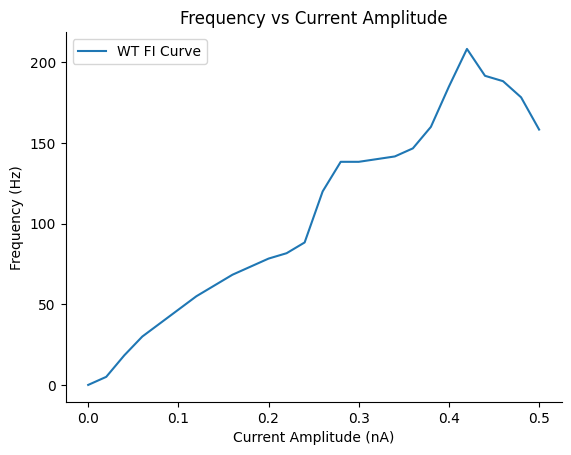

In [24]:
plt.plot(amp_vec,F_vec, label = f"{genotype} FI Curve")
plt.title("Frequency vs Current Amplitude")
plt.xlabel("Current Amplitude (nA)")
plt.ylabel("Frequency (Hz)")
plt.legend()
plt.show()